In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [12]:
# Using the inspector to print the column names and its types
print('Measurement column names and types:')
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
print('---------')
print('Station column names and types:')
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

Measurement column names and types:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
---------
Station column names and types:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Check out data
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [14]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [15]:
# Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [16]:
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

# Exploratory Climate Analysis

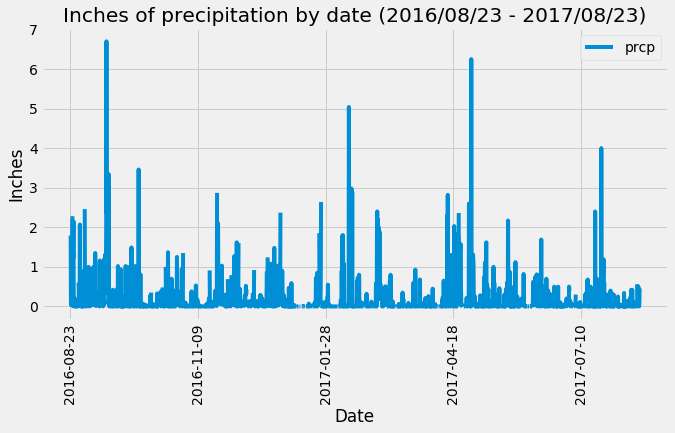

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
sel = [Measurement.date, Measurement.prcp]

# Calculate the date 1 year ago from the last data point in the database
last_date = dt.date(2017, 8 ,23)
date_12mos_ago = last_date - dt.timedelta(days=365)
# date_12mos_ago is 2016-08-23

# Perform a query to retrieve the data and precipitation scores
results = session.query(*sel).filter(Measurement.date >= date_12mos_ago).all()

prcp_date = [result[0] for result in results]
prcp = [result[1] for result in results]

# Save the query results as a Pandas DataFrame
prcp_df = pd.DataFrame(list(zip(prcp_date, prcp)), 
               columns =['prcp_date', 'prcp']) 

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(by=['prcp_date'])

prcp_df

# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot(x='prcp_date', y='prcp', rot=90, figsize=(10,5))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Inches of precipitation by date (2016/08/23 - 2017/08/23)")
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

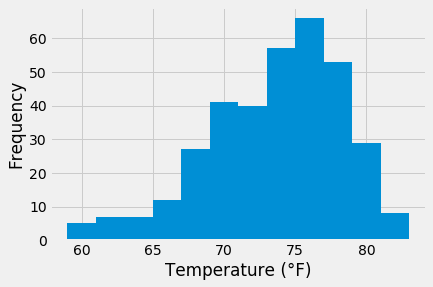

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= date_12mos_ago).all()

temp = [result[0] for result in results]

plt.hist(temp, bins=12)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()


## Bonus Challenge Assignment

In [53]:
# Temperature Analysis I

temp = pd.read_csv("Resources/hawaii_measurements.csv")
temp.head()

june_df = temp[pd.to_datetime(temp['date']).dt.month == 6]
june_df['tobs'].mean()

dec_df = temp[pd.to_datetime(temp['date']).dt.month == 12]
dec_df['tobs'].mean()

# june_avg = session.query(func.avg(Measurement.tobs)).\
#     filter(func.strftime("%m", Measurement.date) == "06").all()

# june_avg = np.ravel(june_avg)

# dec_avg = session.query(func.avg(Measurement.tobs)).\
#     filter(func.strftime("%m", Measurement.date) == "12").all()

# dec_avg = np.ravel(dec_avg)
# dec_avg

# two sample t-test becuase length of samples are different
stats.ttest_ind(june_df['tobs'],dec_df['tobs'])

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

In [24]:
# Temperature Analysis II

# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp = calc_temps('2016-08-23','2017-08-23')
temp

[(58.0, 74.59058295964125, 87.0)]

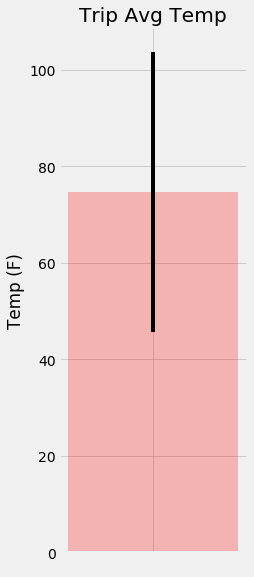

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin, tavg, tmax = temp[0]
t_diff = tmax - tmin

x = np.arange(1)
plt.figure(figsize=(3, 9))
plt.bar(x, tavg, yerr=t_diff, color='red', alpha=0.25, align = 'center')
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.xticks(x, " ")
plt.grid(True)

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates 
# using the previous year's matching dates.
# Sort this in descending order by precipitation amount 
# and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation]

# Perform a query to retrieve the data and precipitation scores
results = session.query(*sel).\
    filter(Measurement.date >= date_12mos_ago).\
    filter(Measurement.date <= last_date).\
    filter(Measurement.station == Station.station).\
    group_by(Station.name).\
    order_by(func.sum(Measurement.prcp).desc()).all()

total_rainfall = pd.DataFrame(results, columns=['Station', 'Precipitation', 'Name', 'Latitude','Longitude','Elevation'])
total_rainfall

,Station,Precipitation,Name,Latitude,Longitude,Elevation
0,USC00516128,147.81,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,70.03,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,48.51,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,38.01,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00514830,33.24,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,16.09,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,4.59,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip

# Set the start and end date of the trip
date1 = '2020-07-01'
date2 = '2020-07-07'

# Use the start and end date to create a range of dates
mydates = pd.date_range(date1, date2).tolist()

# Stip off the year and save a list of %m-%d strings
trip_date = []
for i in range(len(mydates)):
    trip_date.append(dt.datetime.strftime(mydates[i], '%m-%d'))

# push each tuple of calculations into a list called `normals`
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_date:
    day_stats = list(np.ravel(daily_normals(date)))
    normals.append(day_stats)



In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_df = pd.DataFrame(normals, columns=['min_temp','avg_temp','max_temp'])

daily_df['Date'] = mydates
daily_df.set_index('Date', inplace=True)
daily_df

,min_temp,avg_temp,max_temp
Date,,,
2020-07-01,67.0,74.777778,81.0
2020-07-02,68.0,75.403846,82.0
2020-07-03,68.0,75.320755,87.0
2020-07-04,70.0,76.571429,81.0
2020-07-05,66.0,75.000000,81.0
2020-07-06,69.0,75.000000,81.0
2020-07-07,69.0,74.910714,82.0


Text(0, 0.5, 'Temperature')

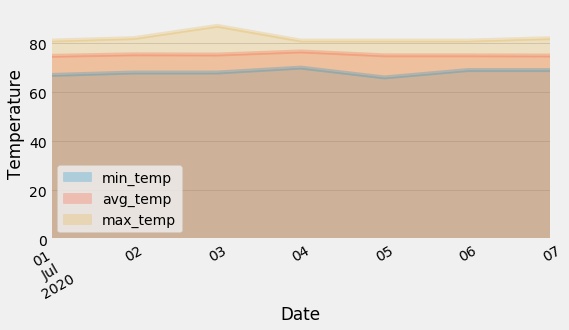

In [48]:
# Plot the daily normals as an area plot with `stacked=False`
ax = daily_df.plot.area(figsize=(8,4),stacked=False, rot=30, alpha = 0.25, ylim=(0,95))
plt.ylabel('Temperature')